In [1]:
import matplotlib.pyplot as plt
from planners.visibility_prm import VisibilityPRM
from utils.visibility_prm_visualize import visibility_prm_visualize
from utils.collision_checker import CollisionChecker
from environment import get_all_scenes

In [2]:
# ---- Konfiguration für VisibilityPRM ----
config = {
    "ntry": 30  # Anzahl der Versuche zur Pfadverbindung
}

# ---- Szenen laden ----
scenes = get_all_scenes()


🔍 Szene: U-Shape
✅ Pfad gefunden in Szene: U-Shape, Länge: 4


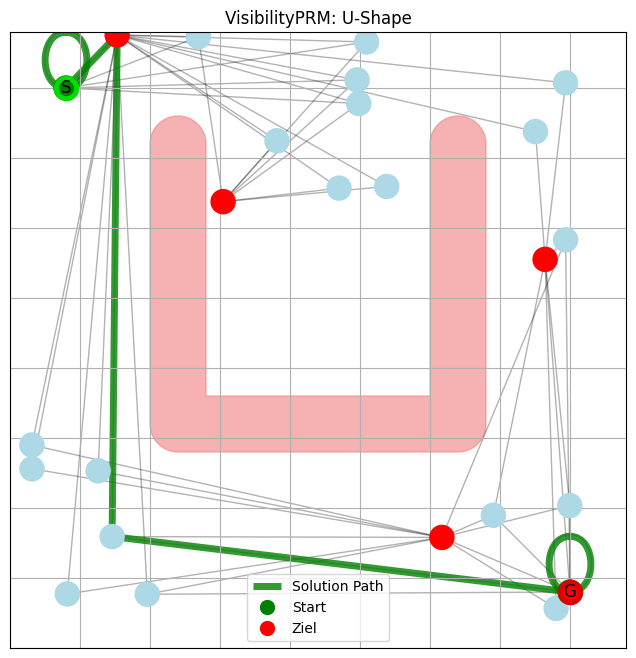


🔍 Szene: L-Shape
✅ Pfad gefunden in Szene: L-Shape, Länge: 5


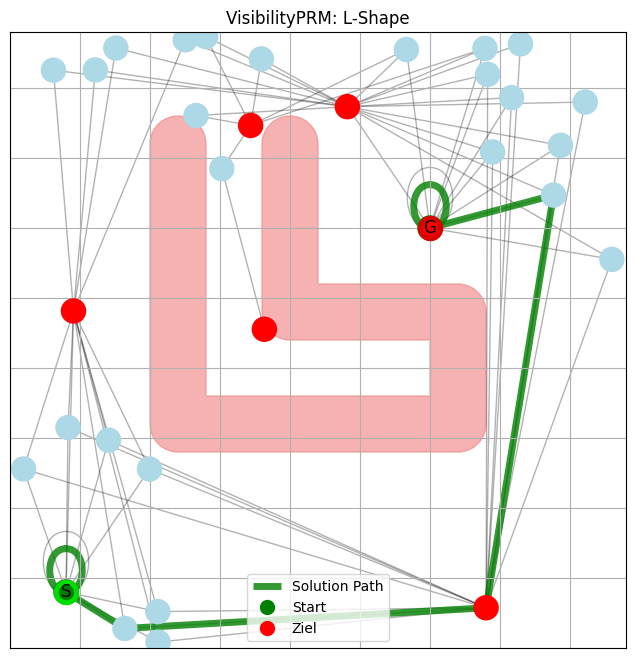


🔍 Szene: Cross-Shape
✅ Pfad gefunden in Szene: Cross-Shape, Länge: 6


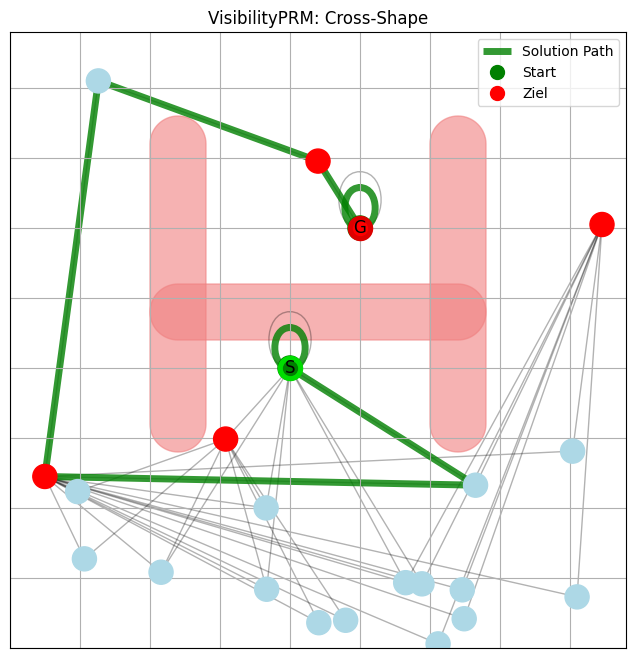


🔍 Szene: Corridor
❌ Kein Pfad gefunden in Szene: Corridor


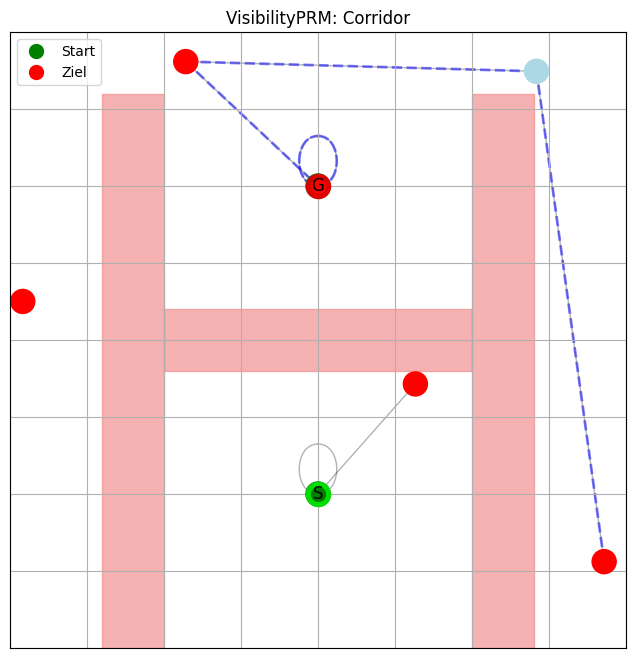


🔍 Szene: Complex Shape
✅ Pfad gefunden in Szene: Complex Shape, Länge: 9


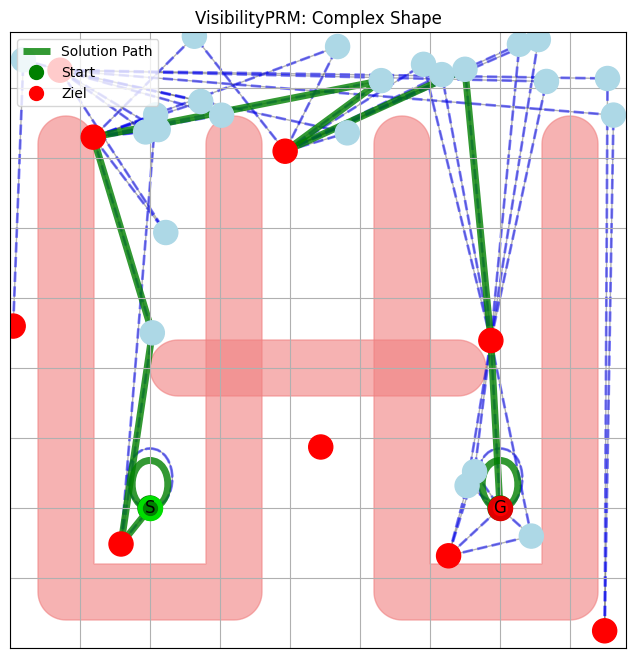


🔍 Szene: Multiple Obstacles
✅ Pfad gefunden in Szene: Multiple Obstacles, Länge: 3


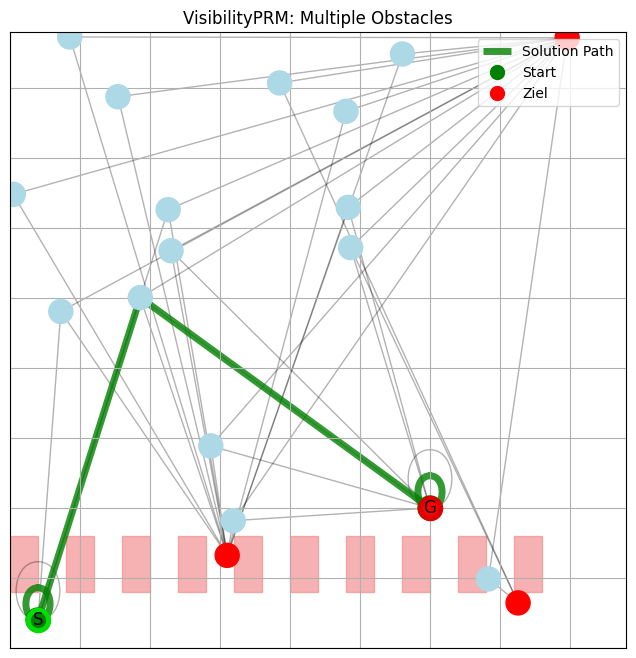


🔍 Szene: Random Obstacles
✅ Pfad gefunden in Szene: Random Obstacles, Länge: 4


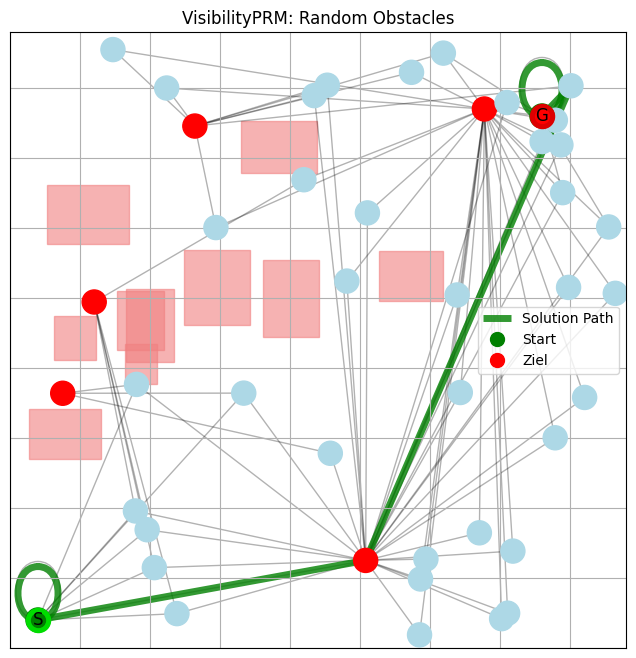

In [3]:
# ---- Jede Szene durchplanen ----
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal = [list(goal_pos)]

    # CollisionChecker initialisieren
    collision_checker = CollisionChecker(scene, limits)

    # Planner initialisieren
    planner = VisibilityPRM(scene, limits)

    # Pfadplanung
    path = planner.plan_path(start, goal, config)

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(path)}")

    # Visualisierung
    fig, ax = plt.subplots(figsize=(8, 8))
    visibility_prm_visualize(planner, path, ax=ax)
    ax.set_title(f"VisibilityPRM: {scene_name}")
    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=10, label="Ziel")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.show()